In [ ]:
##### load synth data
import h5py
import numpy as np
import torch
from synthetic_data import *
import matplotlib.pyplot as plt

from synthetic_data import LorenzSystem, EmbeddedLowDNetwork
        
    
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True

lorenz = LorenzSystem(num_inits= 35,
                        dt= 0.015)
        
net = EmbeddedLowDNetwork(low_d_system = lorenz,
                            net_size = 5,
                            base_rate = 1.0,
                            dt = 0.015)
        
print('lorenz generated')

generator = SyntheticCalciumDataGenerator(system     = net,
                                            seed       = 750,
                                            trainp     = 0.8,
                                            burn_steps = 0,
                                            num_steps  = 10,
                                            num_trials = 10,
                                            tau_cal    = 0.3,
                                            dt_cal     = 0.05,
                                            sigma      = 0.2,
                                            frame_width= 64, 
                                            frame_height=64)

data_dict = generator.generate_dataset()
print('calcium data generated')

# save_data_name = '/home/mila/b/bakhtias/Project-Codes/hierarchical_lfads/synth_data/lorenz_750'
# with h5py.File(save_data_name, 'r') as hf:
#     data_dict = {k: np.array(v) for k, v in hf.items()}
# print(data_dict.keys())



train_dl    = torch.utils.data.DataLoader(SyntheticCalciumVideoDataset(traces= data_dict['train_fluor'], cells=data_dict['cells'], device='cuda'), batch_size=10)
valid_dl    = torch.utils.data.DataLoader(SyntheticCalciumVideoDataset(traces= data_dict['valid_fluor'], cells=data_dict['cells'], device='cuda'), batch_size=10)

print('data loader built')

In [1]:
# miniscope dataloader


import cv2
import numpy as np
import os
import torch
import tempfile
from torchvision import transforms

class MiniscopeDataset(torch.utils.data.Dataset):

    
    def __init__(self, device='cuda', num_workers= 1, tmpdir='/tmp/'):
        
        super(MiniscopeDataset, self).__init__()
            
        self.device = device
        animal_id = 'A0634-201124'
        data_dir = '/network/tmp1/bakhtias/Miniscope/'
        
        
        file_name = os.path.join(data_dir,animal_id,f'{animal_id}_raw.avi')
        cap = cv2.VideoCapture(file_name)
        frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        temporal_downsample_rate = 5
        height = 64
        width = 64
        h_min, h_max = (78,142)
        w_min, w_max = (133,197)
        assert h_max - h_min == height
        assert w_max - w_min == width
        frameCount = 10000
        
        self.transform = transforms.Normalize(110.8592,16.5243)
        self.tempfile = tempfile.TemporaryFile(suffix='.dat', dir='/tmp/')
        self.tensors = (np.memmap(self.tempfile, dtype='float32', mode='w+',shape=(frameCount, 1, height, width)) )

        for fc in range(frameCount):
            ret, temp = cap.read()
            self.tensors[fc] = np.expand_dims(temp[h_min:h_max,w_min:w_max,0],0)
            
        del temp
            
        self.dtype = self[0][0].dtype
        
    def __getitem__(self, ix):
        return (self.transform(torch.from_numpy(self.tensors[ix])).to(self.device), ) #
    
    def __len__(self):
        # return traces.__len__()
        return len(self.tensors)
    
    def close(self):
        self.tempfile.close()
        del self.tensors
        

from torch.utils.data.sampler import SubsetRandomSampler

mindata = MiniscopeDataset()
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 40

# Creating data indices for training and validation splits:
dataset_size = len(mindata)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dl = torch.utils.data.DataLoader(mindata, batch_size=batch_size, 
                                           sampler=train_sampler)
valid_dl = torch.utils.data.DataLoader(mindata, batch_size=batch_size,
                                                sampler=valid_sampler)


In [ ]:
# train slot-attention autoencoder from scratch

import os
from autoencoder_slot_attention import AE_SlotAttention
from scheduler import GradualWarmupScheduler
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt


args = {'exp_id': 2021021201,
        'miniscope': True,
        'batch_size': 100,
        'lr': 0.0001,
        'steplr_step_size': 50,
        'steplr_gamma': 0.9,
        'warmup_multiplier': 1.0,
        'warmup_total_epoch': 1,
        'num_epochs': 1500,
        'out_conv_channels':64,
        'input_dim': 64,
        'num_slots': 20,
        'slot_iter': 10,
        'slot_hidden_dim': 64,
        'img_save_freq': 20,
        'noise_sigma': 0
       }

save_root_path = '/network/tmp1/bakhtias/Results/LFADS/slot-attention'
checkpoint_file_name = os.path.join(save_root_path,f'{args["exp_id"]}.pth.tar')


model = AE_SlotAttention(out_conv_channels = args['out_conv_channels'], 
                             input_dim = args['input_dim'], 
                             num_slots = args['num_slots'], 
                             slot_iter = args['slot_iter'], 
                             slot_hidden_dim = args['slot_hidden_dim'], 
                             device = 'cuda').to('cuda')

run = wandb.init(f"slot-attention-test",config=args)
wandb.watch(model, log='all')
print('\n===========Check Grad============')
for name, param in model.named_parameters():
    print(name, param.requires_grad)
print('=================================\n')

num_epochs = args['num_epochs']  

params = model.parameters()
optimizer = optim.Adam(params, lr=args['lr'], weight_decay=1e-5)

scheduler_steplr = StepLR(optimizer, step_size=args['steplr_step_size'], gamma=args['steplr_gamma'])
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=args['warmup_multiplier'], total_epoch=args['warmup_total_epoch'], after_scheduler=scheduler_steplr)

global iteration; iteration = 0

for epoch in range(num_epochs):
    MSE = 0
    count_tr = 0
    model.train()
    for idx, x in enumerate(tqdm(train_dl)):
            if args['miniscope']:
                x_in = x[0]
            else:
                x_in = x[0].permute(0,2,1,3,4)
                b,t,c,w,h = x_in.shape
                x_in = x_in.reshape(b*t,c,w,h)
                
            x_in = x_in + args['noise_sigma']*torch.randn(x_in.shape,requires_grad = False, device='cuda')
            x_in = x_in - x_in[:].min()
            x_out, _ = model(x_in)
            mse = torch.nn.functional.mse_loss(x_out, x_in, reduction='sum')/x_in.shape[0]
            optimizer.zero_grad()
            mse.backward()
            optimizer.step()
            iteration += 1
            
            MSE += mse
            count_tr += 1
            del mse
            
            
            
    MSE_val = 0        
    count_val = 0 
    which_sample_vis, which_idx = 0, 0
    if epoch % args['img_save_freq'] == 0:
        fig, axs = plt.subplots(1,args['num_slots'])
    model.eval()
    with torch.no_grad(): 
        for idx, x in enumerate(tqdm(valid_dl)):
                if args['miniscope']:
                    x_in = x[0]
                else:
                    x_in = x[0].permute(0,2,1,3,4)
                    b,t,c,w,h = x_in.shape
                    x_in = x_in.reshape(b*t,c,w,h)
                x_in = x_in - x_in[:].min()
                x_out, mask = model(x_in)
                mse_val = torch.nn.functional.mse_loss(x_out, x_in, reduction='sum')/x_in.shape[0]

                MSE_val += mse_val
                count_val += 1
                
                if (epoch % args['img_save_freq'] == 0) and (idx == which_idx):
                    for k in range(args['num_slots']):
                        axs[k].imshow(mask[which_sample_vis,k,:,:].cpu().numpy(),cmap='gray')
                        plt.axis('off')
                        
    if epoch % args['img_save_freq'] == 0:
        wandb.log({"slots":wandb.Image(fig) })
        plt.close()
                
    # save checkpoint            
    if epoch == 0:
        best_MSE = MSE_val
        torch.save({'epoch': epoch+1,
                    'state_dict': model.state_dict(),
                    'best_MSE': best_MSE,
                    'optimizer': optimizer.state_dict(),
                    'iteration': iteration}, checkpoint_file_name)
    else:
        if MSE_val < best_MSE:
            best_MSE = MSE_val
            torch.save({'epoch': epoch+1,
                    'state_dict': model.state_dict(),
                    'best_MSE': best_MSE,
                    'optimizer': optimizer.state_dict(),
                    'iteration': iteration}, checkpoint_file_name)
    
            
    wandb.log({"epoch": epoch, 
                "train loss": MSE/count_tr,
               "val loss": MSE_val/count_val,
               "last_lr": scheduler_warmup.get_last_lr()[0]
                })
    
    
    scheduler_warmup.step(epoch)
    print(f'Epoch: {epoch}    MSE_train: {MSE/count_tr:.2f}    MSE_val: {MSE_val/count_val: .2f}    last_lr:{scheduler_warmup.get_last_lr()[0]}')
    
run.finish()

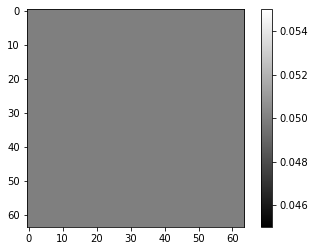

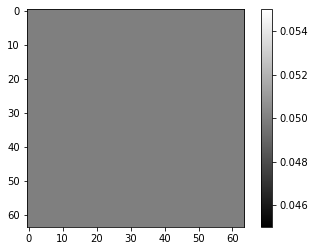

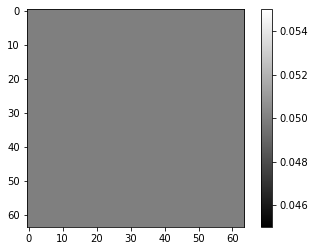

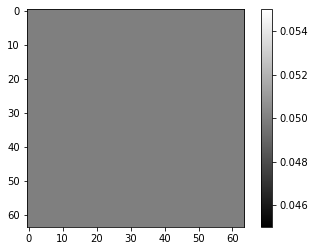

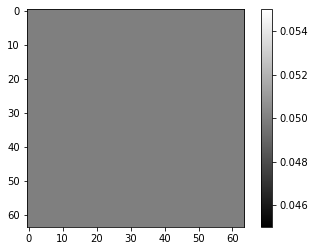

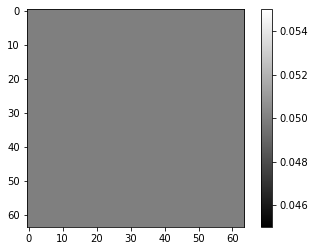

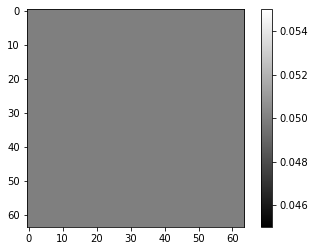

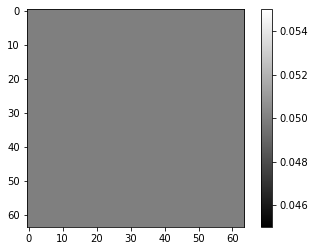

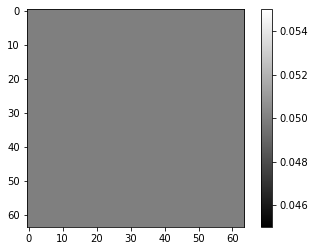

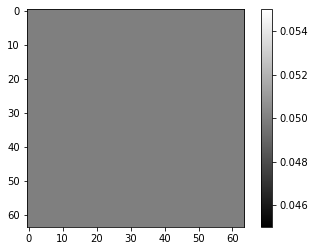

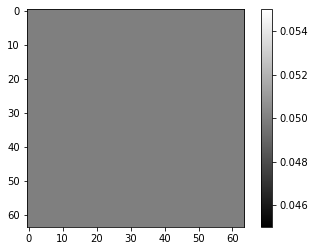

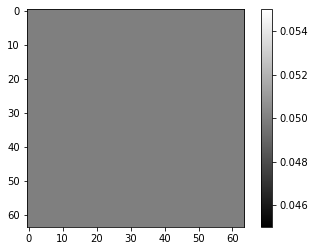

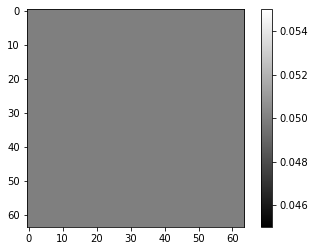

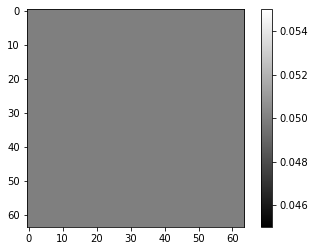

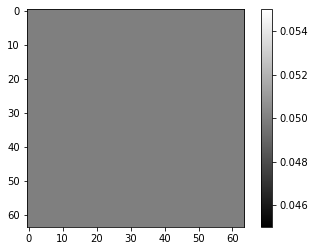

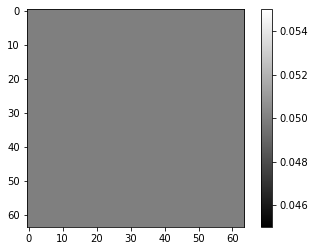

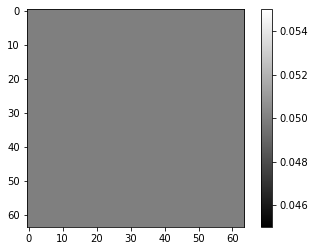

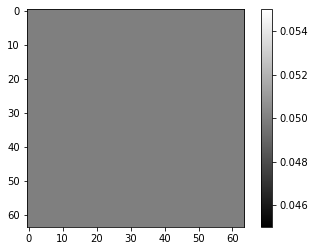

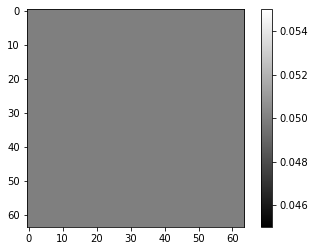

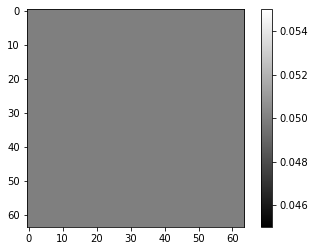

tensor(1.0637, device='cuda:0')


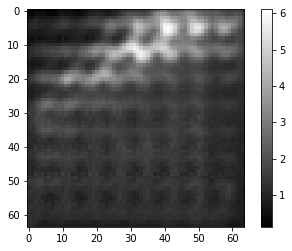

KeyboardInterrupt: 

In [5]:
# visualize results on val data

import os
from autoencoder_slot_attention import AE_SlotAttention
from scheduler import GradualWarmupScheduler
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import wandb
import matplotlib.pyplot as plt

args = {'exp_id': 2021021101,
        'miniscope': True,
        'batch_size': 100,
        'lr': 0.00004,
        'steplr_step_size': 50,
        'steplr_gamma': 0.9,
        'warmup_multiplier': 1.0,
        'warmup_total_epoch': 10,
        'num_epochs': 1500,
        'out_conv_channels':64,
        'input_dim': 64,
        'num_slots':20,
        'slot_iter': 10,
        'slot_hidden_dim': 64,
        'img_save_freq': 20,
        'noise_sigma': 0
       }

save_root_path = '/network/tmp1/bakhtias/Results/LFADS/slot-attention'
checkpoint_file_name = os.path.join(save_root_path,f'{args["exp_id"]}.pth.tar')

model = AE_SlotAttention(out_conv_channels = args['out_conv_channels'], 
                             input_dim = args['input_dim'], 
                             num_slots = args['num_slots'], 
                             slot_iter = args['slot_iter'], 
                             slot_hidden_dim = args['slot_hidden_dim'], 
                             device = 'cuda').to('cuda')

checkpoint = torch.load(checkpoint_file_name, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])

which_sample_vis, which_idx = 35, 0
model.eval()
with torch.no_grad(): 
    for idx, x in enumerate(valid_dl):
            if args['miniscope']:
                x_in = x[0]
            else:
                x_in = x[0].permute(0,2,1,3,4)
                b,t,c,w,h = x_in.shape
                x_in = x_in.reshape(b*t,c,w,h)
            x_in = x_in + args['noise_sigma']*torch.randn(x_in.shape,requires_grad = False, device='cuda')
            x_in = x_in - x_in[:].min()
            x_out, mask = model(x_in)
            mse = torch.nn.functional.mse_loss(x_out, x_in, reduction='sum')/x_in.shape[0]
#             fig, axs = plt.subplots(1,args['num_slots'])
            for k in range(args['num_slots']):
                    
                plt.imshow(mask[0,k,:,:].cpu().numpy(),cmap='gray')#axs[k].imshow(mask[which_sample_vis,k,:,:].cpu().numpy())#
                plt.colorbar()
                plt.show()
            print(x_in[which_sample_vis,0,:,:].std())
            plt.imshow(x_out[which_sample_vis,0,:,:].cpu().numpy(),cmap='gray')
#             plt.clim((0,2))
            plt.colorbar()
            plt.show()
            plt.imshow(x_in[which_sample_vis,0,:,:].cpu().numpy(),cmap='gray')
#             plt.clim((0,2))
            plt.colorbar()
            plt.show()


In [ ]:
# fine tune slot-attention module on a new dataset

import os
from autoencoder_slot_attention import AE_SlotAttention
from scheduler import GradualWarmupScheduler
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import wandb

args = {'exp_id': 2021021101,
        'miniscope': True,
        'batch_size': 10,
        'lr': 0.00004,
        'steplr_step_size': 50,
        'steplr_gamma': 0.9,
        'warmup_multiplier': 1.0,
        'warmup_total_epoch': 10,
        'num_epochs': 1500,
        'out_conv_channels':64,
        'input_dim': 64,
        'num_slots': 10,
        'slot_iter': 10,
        'slot_hidden_dim': 64,
        'img_save_freq': 20,
        'noise_sigma': 0,
        'pretrained': 2021020101
       }


save_root_path = '/network/tmp1/bakhtias/Results/LFADS/slot-attention'
checkpoint_file_name = os.path.join(save_root_path,f'{args["exp_id"]}.pth.tar')
pretrained_checkpoint_file_name = os.path.join(save_root_path,f'{args["pretrained"]}.pth.tar')

model = AE_SlotAttention(out_conv_channels = args['out_conv_channels'], 
                             input_dim = args['input_dim'], 
                             num_slots = args['num_slots'], 
                             slot_iter = args['slot_iter'], 
                             slot_hidden_dim = args['slot_hidden_dim'], 
                             device = 'cuda').to('cuda')

checkpoint = torch.load(pretrained_checkpoint_file_name, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])

run = wandb.init(f"slot-attention-test",config=args)
wandb.watch(model, log='all')

print('\n===========Check Grad============')
for name, param in model.named_parameters():
    if ('slot' not in name) and ('pos_embed' not in name):
        param.requires_grad = False
    print(name, param.requires_grad)
print('=================================\n')
    
num_epochs = args['num_epochs']  
    
params = model.parameters()
optimizer = optim.Adam(params, lr=args['lr'], weight_decay=1e-5)

scheduler_steplr = StepLR(optimizer, step_size=args['steplr_step_size'], gamma=args['steplr_gamma'])
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=args['warmup_multiplier'], total_epoch=args['warmup_total_epoch'], after_scheduler=scheduler_steplr)

global iteration; iteration = 0

for epoch in range(num_epochs):
    MSE = 0
    count_tr = 0
    model.train()
    for idx, x in enumerate(train_dl):
            if args['miniscope']:
                x_in = x[0]
            else:
                x_in = x[0].permute(0,2,1,3,4)
                b,t,c,w,h = x_in.shape
                x_in = x_in.reshape(b*t,c,w,h)
            x_in = x_in + args['noise_sigma']*torch.randn(x_in.shape,requires_grad = False, device='cuda')
            x_in = x_in - x_in[:].min()
            x_out, _ = model(x_in)
            mse = torch.nn.functional.mse_loss(x_out, x_in, reduction='sum')/x_in.shape[0]
            optimizer.zero_grad()
            mse.backward()
            optimizer.step()
            iteration += 1
            
            MSE += mse
            count_tr += 1
            del mse
            
            
            
    MSE_val = 0        
    count_val = 0 
    which_sample_vis = 35
    if epoch % args['img_save_freq'] == 0:
        fig, axs = plt.subplots(len(valid_dl),args['num_slots'])
    model.eval()
    with torch.no_grad(): 
        for idx, x in enumerate(valid_dl):
                if args['miniscope']:
                    x_in = x[0]
                else:
                    x_in = x[0].permute(0,2,1,3,4)
                    b,t,c,w,h = x_in.shape
                    x_in = x_in.reshape(b*t,c,w,h)
                x_in = x_in - x_in[:].min()
                x_out, mask = model(x_in)
                mse_val = torch.nn.functional.mse_loss(x_out, x_in, reduction='sum')/x_in.shape[0]

                MSE_val += mse_val
                count_val += 1
                
                if epoch % args['img_save_freq'] == 0:
                    for k in range(args['num_slots']):
                        axs[idx,k].imshow(mask[which_sample_vis,k,:,:].cpu().numpy(),cmap='gray')
                        plt.axis('off')
                        
    if epoch % args['img_save_freq'] == 0:
        wandb.log({"slots":wandb.Image(fig) })
        plt.close()
                
    # save checkpoint            
    if epoch == 0:
        best_MSE = MSE_val
        torch.save({'epoch': epoch+1,
                    'state_dict': model.state_dict(),
                    'best_MSE': best_MSE,
                    'optimizer': optimizer.state_dict(),
                    'iteration': iteration}, checkpoint_file_name)
    else:
        if MSE_val < best_MSE:
            best_MSE = MSE_val
            torch.save({'epoch': epoch+1,
                    'state_dict': model.state_dict(),
                    'best_MSE': best_MSE,
                    'optimizer': optimizer.state_dict(),
                    'iteration': iteration}, checkpoint_file_name)
    
            
    wandb.log({"epoch": epoch, 
                "train loss": MSE/count_tr,
               "val loss": MSE_val/count_val,
               "last_lr": scheduler_warmup.get_last_lr()[0]
                })
    
    
    scheduler_warmup.step(epoch)
    print(f'Epoch: {epoch}    MSE_train: {MSE/count_tr:.2f}    MSE_val: {MSE_val/count_val: .2f}    last_lr:{scheduler_warmup.get_last_lr()[0]}')
    
run.finish()


In [ ]:
run.finish()

In [ ]:
fig.close()